# Packages

In [1]:
!pip install torchmetrics tqdm --upgrade

# Imports

In [2]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split

from torchmetrics.text import Perplexity

import tqdm

from collections import Counter

2023-09-29 22:34:29.317479: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-29 22:34:29.961139: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Configuration

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
seq_len = 50
batch_size = 25
min_freq = 0

num_epochs = 300

max_lr_dec = 3
lr_dec = 0

# Utils

In [4]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [5]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# Dataset

## Download Dataset

In [6]:
!wget --quiet --continue https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
!unzip -q wikitext-2-v1.zip
!cd wikitext-2 && mv wiki.train.tokens train.txt
!cd wikitext-2 && mv wiki.valid.tokens valid.txt
!cd wikitext-2 && mv wiki.test.tokens test.txt

In [7]:
tokenizer = get_tokenizer("moses")

In [8]:
def load_dataset(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        dataset = file.read()
    return dataset

def tokenize_dataset(dataset):
    tokens = []
    for line in dataset.split('\n'):
        line_tokens = tokenizer(line.strip())
        tokens.extend(line_tokens)
    return tokens

train_dataset = load_dataset("./wikitext-2/train.txt")
valid_dataset = load_dataset("./wikitext-2/valid.txt")
test_dataset = load_dataset("./wikitext-2/test.txt")

train_tokens = tokenize_dataset(train_dataset)
valid_tokens = tokenize_dataset(valid_dataset)
test_tokens = tokenize_dataset(test_dataset)

In [9]:

train_dataset = load_dataset("./wikitext-2/train.txt")
valid_dataset = load_dataset("./wikitext-2/valid.txt")
test_dataset = load_dataset("./wikitext-2/test.txt")

train_tokens = tokenize_dataset(train_dataset)
valid_tokens = tokenize_dataset(valid_dataset)
test_tokens = tokenize_dataset(test_dataset)

all_tokens = train_tokens + valid_tokens + test_tokens
print("Train Tokens: " , len(train_tokens))
print("Valid Tokens: " , len(valid_tokens))
print("Test Tokens: " , len(test_tokens))
print("Total number of tokens:", len(all_tokens))

Train Tokens:  2222445
Valid Tokens:  243937
Test Tokens:  279249
Total number of tokens: 2745631


In [10]:
tokenized_datasets = [train_tokens] 

special_tokens = ['<pad>', '<unk>', '<bos>', '<eos>']

vocab = build_vocab_from_iterator(tokenized_datasets, specials=special_tokens , min_freq=min_freq)

vocab.set_default_index(vocab['<unk>'])

vocab_size = len(vocab)
vocab_itos = vocab.get_itos()

torch.save(vocab, f"./train_vocab_moses_{min_freq}.voc")
print("Vocabulary size:", vocab_size)

Vocabulary size: 33264


## Custom Dataset

In [11]:
class Wikitext2Dataset(Dataset):
  def __init__(self, tokens, seq_len):
    self.tokens = tokens
    self.seq_len = seq_len
  def __len__(self):
    return  len(self.tokens) // self.seq_len

  def __getitem__(self, idx):
    start_idx = idx * self.seq_len
    end_idx = start_idx + self.seq_len
    input = self.tokens[start_idx:end_idx]
    target = self.tokens[start_idx+1:end_idx+1]
    return torch.tensor(input), torch.tensor(target)

## Load Dataset

In [12]:

train_tokens_voc = vocab(train_tokens)
valid_tokens_voc = vocab(valid_tokens)
test_tokens_voc = vocab(test_tokens)

# Datasets
train_dataset = Wikitext2Dataset(train_tokens_voc, seq_len)
valid_dataset = Wikitext2Dataset(valid_tokens_voc, seq_len)
test_dataset = Wikitext2Dataset(test_tokens_voc, seq_len)


# Dataloaders
train_loader = DataLoader(train_dataset , batch_size )
valid_loader = DataLoader(valid_dataset , batch_size )
test_loader = DataLoader(test_dataset , batch_size )

# Model

In [13]:
class H_LSTM(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate):
    super().__init__()
    self.vocab_size = vocab_size
    
    #Embedding Layer
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.dropout_em = nn.Dropout(0.1)
    
    # Layer 1
    self.rnn1 = nn.LSTM(input_size=embedding_dim,
                      hidden_size=hidden_dim,
                      num_layers=num_layers,
                      bidirectional=False,
                      batch_first=True)
    self.dropout1 = nn.Dropout(dropout_rate)
    
    # Layer 2
    self.rnn2 = nn.LSTM(input_size=hidden_dim,
                      hidden_size=hidden_dim,
                      num_layers=num_layers,
                      bidirectional=False,
                      batch_first=True)
    self.dropout2 = nn.Dropout(dropout_rate)
    
    # Layer 3
    self.rnn3 = nn.LSTM(input_size=hidden_dim,
                      hidden_size=hidden_dim,
                      num_layers=1,
                      bidirectional=False,
                      batch_first=True)
    self.dropout3 = nn.Dropout(dropout_rate)
    
    self.fc = nn.Linear(hidden_dim,vocab_size,bias=True)

  def forward(self, src):
    embedding = self.dropout_em( self.embedding(src) )
    
    output, _ = self.rnn1(embedding)
    output = self.dropout1(output)
    
    output, _ = self.rnn2(output)
    output = self.dropout2(output)
    
    output, _ = self.rnn3(output)
    output = self.dropout3(output)
    
    output = self.fc(output)
    return output


# Train

## Learning Functions

In [14]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, perp , epoch=1):
  
  global seq_len
  global batch_size
  
  model.train()
  loss_train = AverageMeter()
  perplexity_train = AverageMeter()
    
  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:

      tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      batch_size, seq_len, vocab_size = outputs.size()
      outputs = outputs.view(batch_size * seq_len, vocab_size)
      targets = targets.view(-1)
      
      loss = loss_fn(outputs, targets)
      
      loss.backward()
      
      perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batch_size, seq_len))
      
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      perplexity_train.update(perplexity.item(), n=len(targets))

      tepoch.set_postfix(loss=loss_train.avg, perplexity = perplexity_train.avg )
      
      del inputs
      del targets
      del outputs

  return model, loss_train.avg, perplexity_train.avg 

In [15]:
def evaluate(model, test_loader, loss_fn , perp ):
  
  global seq_len
  global batch_size
  
  model.eval()
  loss_eval = AverageMeter()
  perplexity_eval = AverageMeter()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      
      batch_size, seq_len, vocab_size = outputs.size()
      outputs = outputs.view(batch_size * seq_len, vocab_size)
      targets = targets.view(-1)

      loss = loss_fn(outputs, targets)
      
      perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batch_size, seq_len))

      loss_eval.update(loss.item(), n=len(targets))
      perplexity_eval.update(perplexity.item(), n=len(targets))
      
      del inputs
      del targets
      del outputs

  return loss_eval.avg,perplexity_eval.avg

## Parameters

In [16]:
embedding_dim = 500
hidden_dim = 500
num_layers = 1
dropout_rate = 0.25

model = H_LSTM( vocab_size, embedding_dim=embedding_dim, hidden_dim=hidden_dim , num_layers=num_layers, dropout_rate= dropout_rate )
loss_train_hist = []
loss_valid_hist = []

per_train_hist = []
per_valid_hist = []

lr_train_hist = []

best_perplexity_valid = torch.inf
epoch_counter = 0
print(f"Trainable Parameters: {num_trainable_params(model)}\n")
model = model.to(device)
model

Trainable Parameters: 39.309264



H_LSTM(
  (embedding): Embedding(33264, 500)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (rnn1): LSTM(500, 500, batch_first=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (rnn2): LSTM(500, 500, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (rnn3): LSTM(500, 500, batch_first=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=500, out_features=33264, bias=True)
)

## Learning Loop

In [17]:
lr = 0.5
wd = 1e-5
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()  
perp = Perplexity().to(device)

In [18]:
num_epochs = 300
max_lr_dec = 4
lr_dec = 0

for epoch in range(num_epochs):
  # Train
  model, loss_train, per_train = train_one_epoch(model, train_loader, loss_fn, optimizer, perp , epoch)
  # Validation
  loss_valid, per_val = evaluate(model, valid_loader, loss_fn, perp)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  per_train_hist.append(per_train)
  per_valid_hist.append(per_val)

  lr_train_hist.append(lr)
  
  print(f'Valid: Loss = {loss_valid:.4} Perplexity= {per_val:.4}, LR = {lr}')
  epoch_counter += 1
  
  if per_val < best_perplexity_valid:
    lr_dec = 0
    torch.save(model, f'model.pt')
    best_perplexity_valid = per_val
    print('Model Saved!')
  else:
    if lr_dec >= max_lr_dec :
      print("LR_DEC==3 , Finished")
      break
    lr_dec += 1
    
    del model
    del perp
    del loss_fn
    del optimizer
    
    model_path = 'model.pt'
    model = torch.load(model_path,map_location=device)
    lr /= 2
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
    loss_fn = nn.CrossEntropyLoss()
    perp = Perplexity().to(device)
  print()
  

Epoch 0: 100%|██████████| 1778/1778 [05:14<00:00,  5.65batch/s, loss=6.16, perplexity=745]    


Valid: Loss = 5.238 Perplexity= 198.1, LR = 0.5
Model Saved!



Epoch 1: 100%|██████████| 1778/1778 [05:39<00:00,  5.24batch/s, loss=5.57, perplexity=271]


Valid: Loss = 5.001 Perplexity= 155.6, LR = 0.5
Model Saved!



Epoch 2: 100%|██████████| 1778/1778 [05:42<00:00,  5.19batch/s, loss=5.35, perplexity=217]


Valid: Loss = 4.869 Perplexity= 136.0, LR = 0.5
Model Saved!



Epoch 3: 100%|██████████| 1778/1778 [05:43<00:00,  5.17batch/s, loss=5.19, perplexity=185]


Valid: Loss = 4.787 Perplexity= 125.3, LR = 0.5
Model Saved!



Epoch 4: 100%|██████████| 1778/1778 [05:44<00:00,  5.16batch/s, loss=5.07, perplexity=165]


Valid: Loss = 4.727 Perplexity= 118.0, LR = 0.5
Model Saved!



Epoch 5: 100%|██████████| 1778/1778 [05:44<00:00,  5.16batch/s, loss=4.97, perplexity=149]


Valid: Loss = 4.685 Perplexity= 113.1, LR = 0.5
Model Saved!



Epoch 6: 100%|██████████| 1778/1778 [05:45<00:00,  5.15batch/s, loss=4.89, perplexity=138]


Valid: Loss = 4.658 Perplexity= 110.2, LR = 0.5
Model Saved!



Epoch 7: 100%|██████████| 1778/1778 [05:46<00:00,  5.14batch/s, loss=4.81, perplexity=128]


Valid: Loss = 4.639 Perplexity= 108.1, LR = 0.5
Model Saved!



Epoch 8: 100%|██████████| 1778/1778 [05:45<00:00,  5.14batch/s, loss=4.75, perplexity=120]


Valid: Loss = 4.622 Perplexity= 106.2, LR = 0.5
Model Saved!



Epoch 9: 100%|██████████| 1778/1778 [05:18<00:00,  5.59batch/s, loss=4.69, perplexity=114]


Valid: Loss = 4.612 Perplexity= 105.2, LR = 0.5
Model Saved!



Epoch 10: 100%|██████████| 1778/1778 [05:29<00:00,  5.40batch/s, loss=4.64, perplexity=108]


Valid: Loss = 4.599 Perplexity= 104.0, LR = 0.5
Model Saved!



Epoch 11: 100%|██████████| 1778/1778 [05:46<00:00,  5.14batch/s, loss=4.6, perplexity=103] 


Valid: Loss = 4.595 Perplexity= 103.6, LR = 0.5
Model Saved!



Epoch 12: 100%|██████████| 1778/1778 [05:46<00:00,  5.14batch/s, loss=4.55, perplexity=99.2]


Valid: Loss = 4.588 Perplexity= 102.9, LR = 0.5
Model Saved!



Epoch 13: 100%|██████████| 1778/1778 [05:45<00:00,  5.14batch/s, loss=4.51, perplexity=95.4]


Valid: Loss = 4.583 Perplexity= 102.4, LR = 0.5
Model Saved!



Epoch 14: 100%|██████████| 1778/1778 [05:46<00:00,  5.14batch/s, loss=4.48, perplexity=92.2]


Valid: Loss = 4.594 Perplexity= 103.6, LR = 0.5



Epoch 15: 100%|██████████| 1778/1778 [05:32<00:00,  5.35batch/s, loss=4.39, perplexity=84.1]


Valid: Loss = 4.518 Perplexity= 96.14, LR = 0.25
Model Saved!



Epoch 16: 100%|██████████| 1778/1778 [05:06<00:00,  5.79batch/s, loss=4.34, perplexity=80.2]


Valid: Loss = 4.514 Perplexity= 95.75, LR = 0.25
Model Saved!



Epoch 17: 100%|██████████| 1778/1778 [05:07<00:00,  5.79batch/s, loss=4.31, perplexity=78]  


Valid: Loss = 4.512 Perplexity= 95.63, LR = 0.25
Model Saved!



Epoch 18: 100%|██████████| 1778/1778 [05:07<00:00,  5.78batch/s, loss=4.28, perplexity=76]  


Valid: Loss = 4.507 Perplexity= 95.18, LR = 0.25
Model Saved!



Epoch 19: 100%|██████████| 1778/1778 [05:07<00:00,  5.78batch/s, loss=4.26, perplexity=74.4]


Valid: Loss = 4.507 Perplexity= 95.26, LR = 0.25



Epoch 20: 100%|██████████| 1778/1778 [05:07<00:00,  5.79batch/s, loss=4.22, perplexity=71.1]


Valid: Loss = 4.461 Perplexity= 90.89, LR = 0.125
Model Saved!



Epoch 21: 100%|██████████| 1778/1778 [05:20<00:00,  5.55batch/s, loss=4.19, perplexity=69]  


Valid: Loss = 4.459 Perplexity= 90.72, LR = 0.125
Model Saved!



Epoch 22: 100%|██████████| 1778/1778 [05:34<00:00,  5.32batch/s, loss=4.17, perplexity=67.6]


Valid: Loss = 4.457 Perplexity= 90.61, LR = 0.125
Model Saved!



Epoch 23: 100%|██████████| 1778/1778 [05:18<00:00,  5.59batch/s, loss=4.15, perplexity=66.5]


Valid: Loss = 4.452 Perplexity= 90.2, LR = 0.125
Model Saved!



Epoch 24: 100%|██████████| 1778/1778 [05:18<00:00,  5.58batch/s, loss=4.14, perplexity=65.5]


Valid: Loss = 4.453 Perplexity= 90.25, LR = 0.125



Epoch 25: 100%|██████████| 1778/1778 [05:19<00:00,  5.56batch/s, loss=4.12, perplexity=64.6]


Valid: Loss = 4.417 Perplexity= 87.09, LR = 0.0625
Model Saved!



Epoch 26: 100%|██████████| 1778/1778 [05:23<00:00,  5.50batch/s, loss=4.1, perplexity=63.4] 


Valid: Loss = 4.413 Perplexity= 86.71, LR = 0.0625
Model Saved!



Epoch 27: 100%|██████████| 1778/1778 [05:20<00:00,  5.55batch/s, loss=4.09, perplexity=62.7]


Valid: Loss = 4.41 Perplexity= 86.52, LR = 0.0625
Model Saved!



Epoch 28: 100%|██████████| 1778/1778 [05:44<00:00,  5.16batch/s, loss=4.08, perplexity=62.1]


Valid: Loss = 4.41 Perplexity= 86.45, LR = 0.0625
Model Saved!



Epoch 29: 100%|██████████| 1778/1778 [05:46<00:00,  5.14batch/s, loss=4.07, perplexity=61.4]


Valid: Loss = 4.412 Perplexity= 86.69, LR = 0.0625



Epoch 30: 100%|██████████| 1778/1778 [05:46<00:00,  5.14batch/s, loss=4.07, perplexity=61.6]


Valid: Loss = 4.388 Perplexity= 84.52, LR = 0.03125
Model Saved!



Epoch 31: 100%|██████████| 1778/1778 [05:46<00:00,  5.13batch/s, loss=4.06, perplexity=61]  


Valid: Loss = 4.385 Perplexity= 84.26, LR = 0.03125
Model Saved!



Epoch 32: 100%|██████████| 1778/1778 [05:46<00:00,  5.13batch/s, loss=4.06, perplexity=60.6]


Valid: Loss = 4.381 Perplexity= 83.96, LR = 0.03125
Model Saved!



Epoch 33: 100%|██████████| 1778/1778 [05:15<00:00,  5.63batch/s, loss=4.05, perplexity=60.2]


Valid: Loss = 4.381 Perplexity= 83.94, LR = 0.03125
Model Saved!



Epoch 34: 100%|██████████| 1778/1778 [05:08<00:00,  5.77batch/s, loss=4.04, perplexity=59.8]


Valid: Loss = 4.38 Perplexity= 83.9, LR = 0.03125
Model Saved!



Epoch 35: 100%|██████████| 1778/1778 [05:08<00:00,  5.77batch/s, loss=4.04, perplexity=59.4]


Valid: Loss = 4.378 Perplexity= 83.71, LR = 0.03125
Model Saved!



Epoch 36: 100%|██████████| 1778/1778 [05:08<00:00,  5.76batch/s, loss=4.03, perplexity=59.1]


Valid: Loss = 4.377 Perplexity= 83.64, LR = 0.03125
Model Saved!



Epoch 37: 100%|██████████| 1778/1778 [05:08<00:00,  5.76batch/s, loss=4.03, perplexity=58.7]


Valid: Loss = 4.373 Perplexity= 83.34, LR = 0.03125
Model Saved!



Epoch 38: 100%|██████████| 1778/1778 [05:08<00:00,  5.76batch/s, loss=4.02, perplexity=58.4]


Valid: Loss = 4.372 Perplexity= 83.19, LR = 0.03125
Model Saved!



Epoch 39: 100%|██████████| 1778/1778 [05:08<00:00,  5.76batch/s, loss=4.02, perplexity=58.1]


Valid: Loss = 4.372 Perplexity= 83.27, LR = 0.03125



Epoch 40: 100%|██████████| 1778/1778 [05:08<00:00,  5.76batch/s, loss=4.02, perplexity=58.5]


Valid: Loss = 4.358 Perplexity= 82.0, LR = 0.015625
Model Saved!



Epoch 41: 100%|██████████| 1778/1778 [05:08<00:00,  5.76batch/s, loss=4.02, perplexity=58.2]


Valid: Loss = 4.357 Perplexity= 81.93, LR = 0.015625
Model Saved!



Epoch 42: 100%|██████████| 1778/1778 [05:08<00:00,  5.76batch/s, loss=4.01, perplexity=58]  


Valid: Loss = 4.356 Perplexity= 81.87, LR = 0.015625
Model Saved!



Epoch 43: 100%|██████████| 1778/1778 [05:08<00:00,  5.76batch/s, loss=4.01, perplexity=57.8]


Valid: Loss = 4.358 Perplexity= 81.99, LR = 0.015625



Epoch 44: 100%|██████████| 1778/1778 [05:08<00:00,  5.76batch/s, loss=4.02, perplexity=58.6]


Valid: Loss = 4.344 Perplexity= 80.87, LR = 0.0078125
Model Saved!



Epoch 45: 100%|██████████| 1778/1778 [05:08<00:00,  5.76batch/s, loss=4.02, perplexity=58.5]


Valid: Loss = 4.344 Perplexity= 80.83, LR = 0.0078125
Model Saved!



Epoch 46: 100%|██████████| 1778/1778 [05:09<00:00,  5.75batch/s, loss=4.02, perplexity=58.5]


Valid: Loss = 4.343 Perplexity= 80.77, LR = 0.0078125
Model Saved!



Epoch 47: 100%|██████████| 1778/1778 [05:09<00:00,  5.75batch/s, loss=4.02, perplexity=58.3]


Valid: Loss = 4.343 Perplexity= 80.81, LR = 0.0078125



Epoch 48: 100%|██████████| 1778/1778 [05:09<00:00,  5.75batch/s, loss=4.03, perplexity=59.1]


Valid: Loss = 4.334 Perplexity= 79.99, LR = 0.00390625
Model Saved!



Epoch 49: 100%|██████████| 1778/1778 [05:09<00:00,  5.75batch/s, loss=4.03, perplexity=59.1]


Valid: Loss = 4.332 Perplexity= 79.85, LR = 0.00390625
Model Saved!



Epoch 50: 100%|██████████| 1778/1778 [05:09<00:00,  5.75batch/s, loss=4.03, perplexity=59]  


Valid: Loss = 4.331 Perplexity= 79.83, LR = 0.00390625
Model Saved!



Epoch 51: 100%|██████████| 1778/1778 [05:09<00:00,  5.75batch/s, loss=4.03, perplexity=58.9]


Valid: Loss = 4.331 Perplexity= 79.83, LR = 0.00390625
Model Saved!



Epoch 52: 100%|██████████| 1778/1778 [05:09<00:00,  5.75batch/s, loss=4.02, perplexity=58.8]


Valid: Loss = 4.33 Perplexity= 79.67, LR = 0.00390625
Model Saved!



Epoch 53: 100%|██████████| 1778/1778 [05:09<00:00,  5.75batch/s, loss=4.02, perplexity=58.7]


Valid: Loss = 4.331 Perplexity= 79.76, LR = 0.00390625



Epoch 54: 100%|██████████| 1778/1778 [05:09<00:00,  5.75batch/s, loss=4.03, perplexity=59.1]


Valid: Loss = 4.322 Perplexity= 79.02, LR = 0.001953125
Model Saved!



Epoch 55: 100%|██████████| 1778/1778 [05:09<00:00,  5.74batch/s, loss=4.03, perplexity=59.1]


Valid: Loss = 4.32 Perplexity= 78.89, LR = 0.001953125
Model Saved!



Epoch 56: 100%|██████████| 1778/1778 [05:09<00:00,  5.75batch/s, loss=4.03, perplexity=58.9]


Valid: Loss = 4.32 Perplexity= 78.9, LR = 0.001953125



Epoch 57: 100%|██████████| 1778/1778 [05:09<00:00,  5.75batch/s, loss=4.03, perplexity=59.1]


Valid: Loss = 4.316 Perplexity= 78.56, LR = 0.0009765625
Model Saved!



Epoch 58: 100%|██████████| 1778/1778 [05:09<00:00,  5.75batch/s, loss=4.03, perplexity=59]  


Valid: Loss = 4.315 Perplexity= 78.51, LR = 0.0009765625
Model Saved!



Epoch 59: 100%|██████████| 1778/1778 [05:09<00:00,  5.74batch/s, loss=4.02, perplexity=58.8]


Valid: Loss = 4.315 Perplexity= 78.48, LR = 0.0009765625
Model Saved!



Epoch 60: 100%|██████████| 1778/1778 [05:09<00:00,  5.74batch/s, loss=4.02, perplexity=58.8]


Valid: Loss = 4.315 Perplexity= 78.47, LR = 0.0009765625
Model Saved!



Epoch 61: 100%|██████████| 1778/1778 [05:09<00:00,  5.74batch/s, loss=4.02, perplexity=58.8]


Valid: Loss = 4.314 Perplexity= 78.45, LR = 0.0009765625
Model Saved!



Epoch 62: 100%|██████████| 1778/1778 [05:09<00:00,  5.74batch/s, loss=4.02, perplexity=58.7]


Valid: Loss = 4.314 Perplexity= 78.45, LR = 0.0009765625
Model Saved!



Epoch 63: 100%|██████████| 1778/1778 [05:09<00:00,  5.74batch/s, loss=4.02, perplexity=58.7]


Valid: Loss = 4.314 Perplexity= 78.45, LR = 0.0009765625



Epoch 64: 100%|██████████| 1778/1778 [05:09<00:00,  5.74batch/s, loss=4.02, perplexity=58.7]


Valid: Loss = 4.313 Perplexity= 78.34, LR = 0.00048828125
Model Saved!



Epoch 65: 100%|██████████| 1778/1778 [05:09<00:00,  5.74batch/s, loss=4.02, perplexity=58.7]


Valid: Loss = 4.313 Perplexity= 78.31, LR = 0.00048828125
Model Saved!



Epoch 66: 100%|██████████| 1778/1778 [05:09<00:00,  5.74batch/s, loss=4.02, perplexity=58.7]


Valid: Loss = 4.313 Perplexity= 78.3, LR = 0.00048828125
Model Saved!



Epoch 67: 100%|██████████| 1778/1778 [05:09<00:00,  5.74batch/s, loss=4.02, perplexity=58.6]


Valid: Loss = 4.312 Perplexity= 78.29, LR = 0.00048828125
Model Saved!



Epoch 68: 100%|██████████| 1778/1778 [05:09<00:00,  5.74batch/s, loss=4.02, perplexity=58.6]


Valid: Loss = 4.312 Perplexity= 78.28, LR = 0.00048828125
Model Saved!



Epoch 69: 100%|██████████| 1778/1778 [05:09<00:00,  5.74batch/s, loss=4.02, perplexity=58.6]


Valid: Loss = 4.312 Perplexity= 78.28, LR = 0.00048828125
Model Saved!



Epoch 70: 100%|██████████| 1778/1778 [05:10<00:00,  5.73batch/s, loss=4.02, perplexity=58.6]


Valid: Loss = 4.312 Perplexity= 78.27, LR = 0.00048828125
Model Saved!



Epoch 71: 100%|██████████| 1778/1778 [05:09<00:00,  5.74batch/s, loss=4.02, perplexity=58.5]


Valid: Loss = 4.312 Perplexity= 78.27, LR = 0.00048828125



Epoch 72: 100%|██████████| 1778/1778 [05:10<00:00,  5.73batch/s, loss=4.02, perplexity=58.6]


Valid: Loss = 4.312 Perplexity= 78.24, LR = 0.000244140625
Model Saved!



Epoch 73: 100%|██████████| 1778/1778 [05:10<00:00,  5.73batch/s, loss=4.02, perplexity=58.5]


Valid: Loss = 4.312 Perplexity= 78.23, LR = 0.000244140625
Model Saved!



Epoch 74: 100%|██████████| 1778/1778 [05:10<00:00,  5.73batch/s, loss=4.02, perplexity=58.5]


Valid: Loss = 4.312 Perplexity= 78.23, LR = 0.000244140625
Model Saved!



Epoch 75: 100%|██████████| 1778/1778 [05:10<00:00,  5.73batch/s, loss=4.02, perplexity=58.5]


Valid: Loss = 4.311 Perplexity= 78.21, LR = 0.000244140625
Model Saved!



Epoch 76: 100%|██████████| 1778/1778 [05:09<00:00,  5.74batch/s, loss=4.02, perplexity=58.5]


Valid: Loss = 4.311 Perplexity= 78.21, LR = 0.000244140625
Model Saved!



Epoch 77: 100%|██████████| 1778/1778 [05:09<00:00,  5.74batch/s, loss=4.02, perplexity=58.5]


Valid: Loss = 4.311 Perplexity= 78.21, LR = 0.000244140625
Model Saved!



Epoch 78: 100%|██████████| 1778/1778 [05:10<00:00,  5.73batch/s, loss=4.02, perplexity=58.5]


Valid: Loss = 4.311 Perplexity= 78.21, LR = 0.000244140625



Epoch 79: 100%|██████████| 1778/1778 [05:09<00:00,  5.74batch/s, loss=4.02, perplexity=58.5]


Valid: Loss = 4.311 Perplexity= 78.2, LR = 0.0001220703125
Model Saved!



Epoch 80: 100%|██████████| 1778/1778 [05:09<00:00,  5.74batch/s, loss=4.02, perplexity=58.5]


Valid: Loss = 4.311 Perplexity= 78.2, LR = 0.0001220703125
Model Saved!



Epoch 81: 100%|██████████| 1778/1778 [05:09<00:00,  5.74batch/s, loss=4.02, perplexity=58.5]


Valid: Loss = 4.311 Perplexity= 78.2, LR = 0.0001220703125
Model Saved!



Epoch 82: 100%|██████████| 1778/1778 [05:10<00:00,  5.73batch/s, loss=4.02, perplexity=58.5]


Valid: Loss = 4.311 Perplexity= 78.19, LR = 0.0001220703125
Model Saved!



Epoch 83: 100%|██████████| 1778/1778 [05:10<00:00,  5.73batch/s, loss=4.02, perplexity=58.4]


Valid: Loss = 4.311 Perplexity= 78.19, LR = 0.0001220703125
Model Saved!



Epoch 84: 100%|██████████| 1778/1778 [05:09<00:00,  5.74batch/s, loss=4.02, perplexity=58.4]


Valid: Loss = 4.311 Perplexity= 78.19, LR = 0.0001220703125
Model Saved!



Epoch 85: 100%|██████████| 1778/1778 [05:09<00:00,  5.74batch/s, loss=4.02, perplexity=58.5]


Valid: Loss = 4.311 Perplexity= 78.19, LR = 0.0001220703125



Epoch 86: 100%|██████████| 1778/1778 [05:09<00:00,  5.74batch/s, loss=4.02, perplexity=58.4]


Valid: Loss = 4.311 Perplexity= 78.19, LR = 6.103515625e-05
Model Saved!



Epoch 87: 100%|██████████| 1778/1778 [05:09<00:00,  5.74batch/s, loss=4.02, perplexity=58.4]


Valid: Loss = 4.311 Perplexity= 78.19, LR = 6.103515625e-05
Model Saved!



Epoch 88: 100%|██████████| 1778/1778 [05:09<00:00,  5.74batch/s, loss=4.02, perplexity=58.4]


Valid: Loss = 4.311 Perplexity= 78.18, LR = 6.103515625e-05
Model Saved!



Epoch 89: 100%|██████████| 1778/1778 [05:18<00:00,  5.59batch/s, loss=4.02, perplexity=58.4]


Valid: Loss = 4.311 Perplexity= 78.18, LR = 6.103515625e-05
Model Saved!



Epoch 90: 100%|██████████| 1778/1778 [05:29<00:00,  5.40batch/s, loss=4.02, perplexity=58.4]


Valid: Loss = 4.311 Perplexity= 78.18, LR = 6.103515625e-05



Epoch 91: 100%|██████████| 1778/1778 [05:53<00:00,  5.04batch/s, loss=4.02, perplexity=58.4]


Valid: Loss = 4.311 Perplexity= 78.18, LR = 3.0517578125e-05
Model Saved!



Epoch 92: 100%|██████████| 1778/1778 [05:51<00:00,  5.06batch/s, loss=4.02, perplexity=58.4]


Valid: Loss = 4.311 Perplexity= 78.18, LR = 3.0517578125e-05



Epoch 93: 100%|██████████| 1778/1778 [05:50<00:00,  5.07batch/s, loss=4.02, perplexity=58.4]


Valid: Loss = 4.311 Perplexity= 78.18, LR = 1.52587890625e-05
Model Saved!



Epoch 94: 100%|██████████| 1778/1778 [05:49<00:00,  5.09batch/s, loss=4.02, perplexity=58.4]


Valid: Loss = 4.311 Perplexity= 78.18, LR = 1.52587890625e-05
Model Saved!



Epoch 95: 100%|██████████| 1778/1778 [05:40<00:00,  5.22batch/s, loss=4.02, perplexity=58.4]


Valid: Loss = 4.311 Perplexity= 78.18, LR = 1.52587890625e-05



Epoch 96: 100%|██████████| 1778/1778 [05:09<00:00,  5.75batch/s, loss=4.02, perplexity=58.4]


Valid: Loss = 4.311 Perplexity= 78.18, LR = 7.62939453125e-06



Epoch 97: 100%|██████████| 1778/1778 [05:09<00:00,  5.75batch/s, loss=4.02, perplexity=58.4]


Valid: Loss = 4.311 Perplexity= 78.18, LR = 3.814697265625e-06
Model Saved!



Epoch 98: 100%|██████████| 1778/1778 [05:09<00:00,  5.75batch/s, loss=4.02, perplexity=58.4]


Valid: Loss = 4.311 Perplexity= 78.18, LR = 3.814697265625e-06



Epoch 99: 100%|██████████| 1778/1778 [05:08<00:00,  5.76batch/s, loss=4.02, perplexity=58.4]


Valid: Loss = 4.311 Perplexity= 78.18, LR = 1.9073486328125e-06
Model Saved!



Epoch 100: 100%|██████████| 1778/1778 [05:08<00:00,  5.76batch/s, loss=4.02, perplexity=58.4]


Valid: Loss = 4.311 Perplexity= 78.18, LR = 1.9073486328125e-06



Epoch 101: 100%|██████████| 1778/1778 [05:09<00:00,  5.75batch/s, loss=4.02, perplexity=58.4]


Valid: Loss = 4.311 Perplexity= 78.18, LR = 9.5367431640625e-07



Epoch 102: 100%|██████████| 1778/1778 [05:08<00:00,  5.75batch/s, loss=4.02, perplexity=58.4]


Valid: Loss = 4.311 Perplexity= 78.18, LR = 4.76837158203125e-07



Epoch 103: 100%|██████████| 1778/1778 [05:08<00:00,  5.76batch/s, loss=4.02, perplexity=58.4]


Valid: Loss = 4.311 Perplexity= 78.18, LR = 2.384185791015625e-07



Epoch 104: 100%|██████████| 1778/1778 [05:08<00:00,  5.76batch/s, loss=4.02, perplexity=58.4]


Valid: Loss = 4.311 Perplexity= 78.18, LR = 1.1920928955078125e-07
LR_DEC==3 , Finished


## Learning Curve

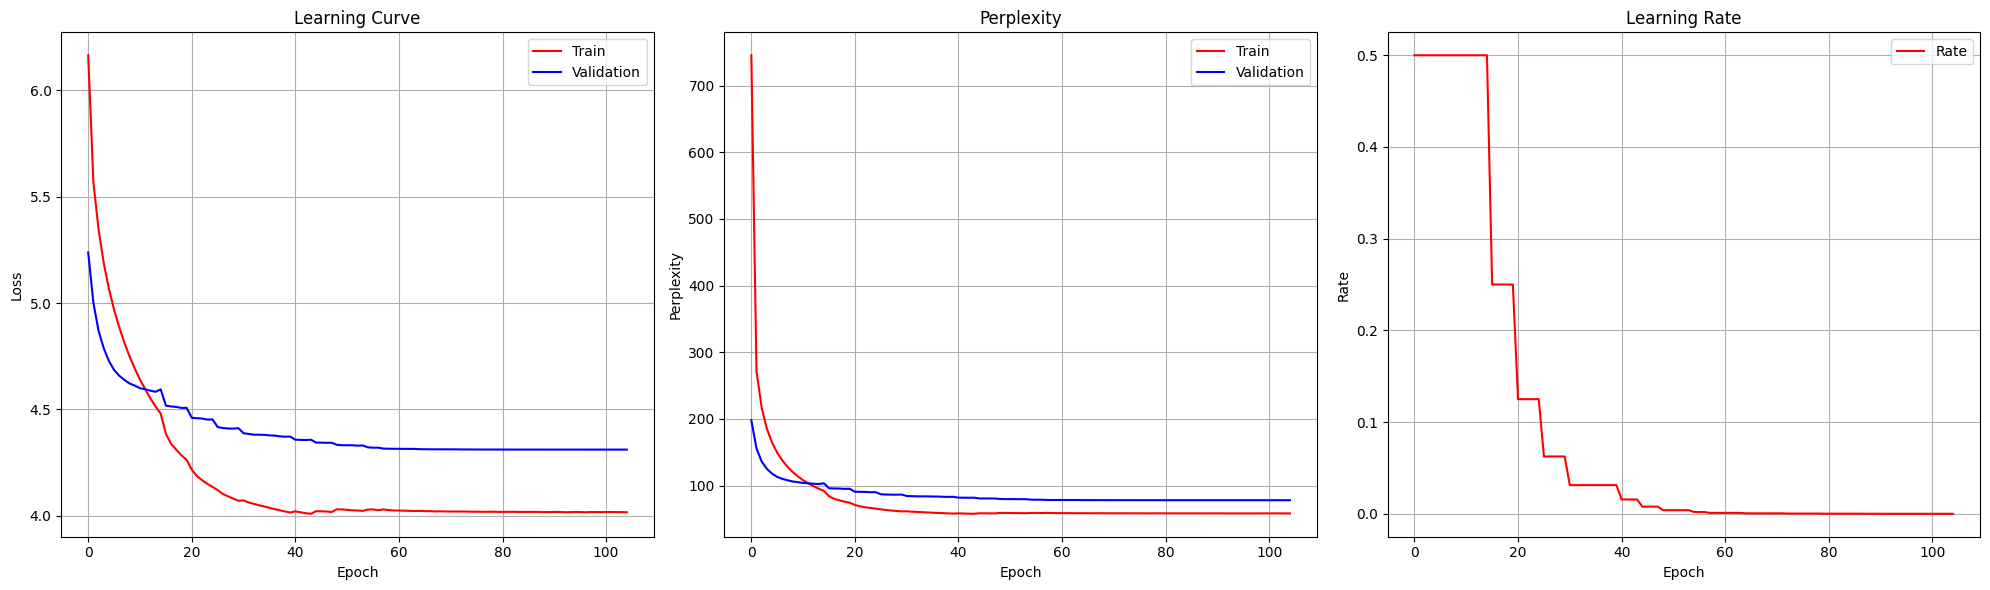

In [19]:
# Save as CSV
import pandas as pd
datas = {
    'epoch': range(epoch_counter),
    'loss_train': loss_train_hist,
    'loss_validation': loss_valid_hist,
    'perplexity_train': per_train_hist , 
    'perplexity_validation':per_valid_hist,
    'learning_rate': lr_train_hist
}
df = pd.DataFrame(datas)
df.to_csv("learningCurve.csv" , index=False)

fig, (ax1, ax2 , ax3) = plt.subplots(1, 3, figsize=(20, 6))

ax1.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
ax1.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')
ax1.set_title('Learning Curve')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

ax2.plot(range(epoch_counter), per_train_hist, 'r-', label='Train')
ax2.plot(range(epoch_counter), per_valid_hist, 'b-', label='Validation')
ax2.set_title('Perplexity')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Perplexity')
ax2.grid(True)
ax2.legend()

ax3.plot(range(epoch_counter), lr_train_hist, 'r-', label='Rate')
ax3.set_title('Learning Rate')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Rate')
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()

## Test Perplexity

In [20]:
#LanguageModel = H_LSTM

model_path = 'model.pt'
model = torch.load(model_path)
model = model.to(device)
model.eval()

loss_fn = nn.CrossEntropyLoss()
perp = Perplexity().to(device)

loss_valid , per_valid  = evaluate(model, valid_loader, loss_fn , perp )
print(f"Validation: Loss = {loss_valid:.4} , Perplexity = {per_valid:.4}")

loss_test , per_test  = evaluate(model, test_loader, loss_fn , perp)
print(f"Test: Loss = {loss_test:.4} , Perplexity = {per_test:.4}")

Validation: Loss = 4.311 , Perplexity = 78.18
Test: Loss = 4.198 , Perplexity = 72.07


# Text Generation

In [21]:
loss_fn = nn.CrossEntropyLoss()

model_path = 'model.pt'
model = torch.load(model_path)
model = model.to(device)
model.eval()
model

H_LSTM(
  (embedding): Embedding(33264, 500)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (rnn1): LSTM(500, 500, batch_first=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (rnn2): LSTM(500, 500, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (rnn3): LSTM(500, 500, batch_first=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=500, out_features=33264, bias=True)
)

In [22]:
num_trainable_params(model)

39.309264

In [38]:
def generate(prompt, max_seq_len, temperature, model ):

    global device
    global vocab_itos
    global seq_len
    global char2ind
    
    prompt_tokens = prompt.split(' ')
    prompt_tokens = [vocab[token] for token in prompt_tokens]  

    with torch.no_grad():
        current_token = torch.tensor(prompt_tokens).unsqueeze(0) 
        current_token = current_token.to(device)
        generated_text = prompt  
        for i in range(max_seq_len):
            output = model(current_token)
            probabilities = nn.functional.softmax(output[:, -1, :] / temperature, dim=-1)
            next_word = "<unk>"
            while next_word == "<unk>":
                next_token_id = torch.multinomial(probabilities, 1).item()
                next_word = vocab_itos[next_token_id]
            
            generated_text += " " + next_word

            next_token_id = torch.tensor([[next_token_id]]).to(device)
            if current_token.shape[1] < seq_len:
                current_token = torch.cat( ( current_token  , next_token_id ), dim=1)
            else:
                current_token = torch.cat( ( current_token[:, 1:]  , next_token_id ), dim=1)
            if next_word in ["<eos>", "."]:
                break
            del next_token_id
    return generated_text

prompt = "i think the movie"
generated_text = generate(prompt, 
                          max_seq_len = 100, 
                          temperature = 0.5, 
                          model = model)

print(generated_text)

i think the movie is difficult to get , but it is not a question that is really &lt; unk &gt; , and that it does not mean that it is a very good view .
